In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Reading Data Folder and the Template Files

In [2]:
data_folder = '/Users/jaswantjonnada/Documents/TestRequestForm/data/images/snapmmd'

LIFECELL_TEMPLATE = '/Users/jaswantjonnada/Documents/TestRequestForm/templates/Lifecell_Routine_TRF-1.png'
MFINE_TEMPLATE = '/Users/jaswantjonnada/Documents/TestRequestForm/templates/MFine_TRF.png'

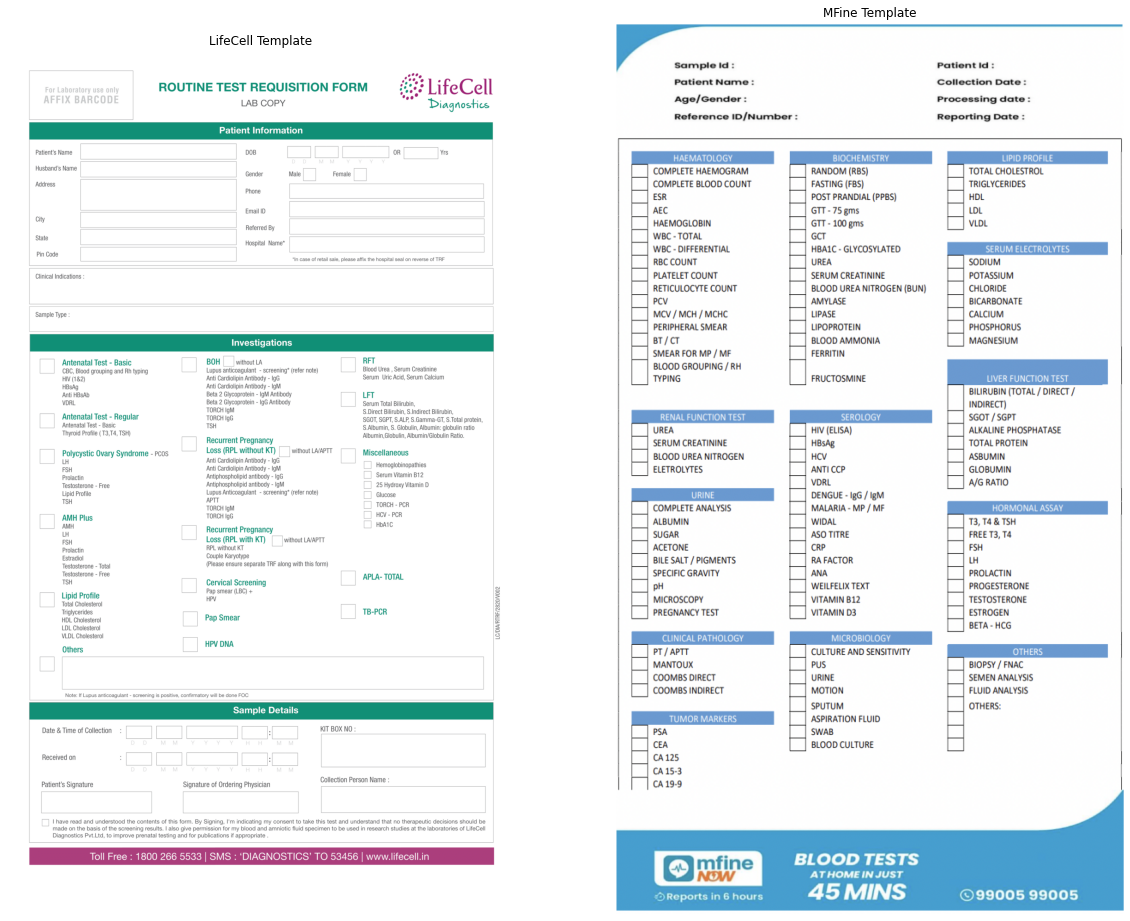

In [3]:

# Reading the Template Images and change it to grey
lifecell_template_im = cv2.imread(LIFECELL_TEMPLATE)
lifecell_template_im = cv2.cvtColor(lifecell_template_im, cv2.COLOR_BGR2RGB)
lifecell_template_grey = cv2.cvtColor(lifecell_template_im, cv2.COLOR_RGB2GRAY)

mfine_template_im = cv2.imread(MFINE_TEMPLATE)
mfine_template_im = cv2.cvtColor(mfine_template_im, cv2.COLOR_BGR2RGB)
mfine_template_grey = cv2.cvtColor(mfine_template_im, cv2.COLOR_RGB2GRAY)

# Plotting Template Images
plt.figure(figsize = (20, 40))
ax1 = plt.subplot(221)

ax1.axis('off')
ax1.set_title('LifeCell Template')
ax1.imshow(lifecell_template_im)

ax2 = plt.subplot(222)
ax2.axis('off')
ax2.set_title('MFine Template')
ax2.imshow(mfine_template_im)

In [4]:
print(f'Lifecell Template Shape: {lifecell_template_im.shape}')
print(f'Mfine Template Shape: {mfine_template_im.shape}')

Lifecell Template Shape: (2800, 1700, 3)
Mfine Template Shape: (1324, 754, 3)


Reading Query Images

Query Image Shape: (4000, 3000, 3)


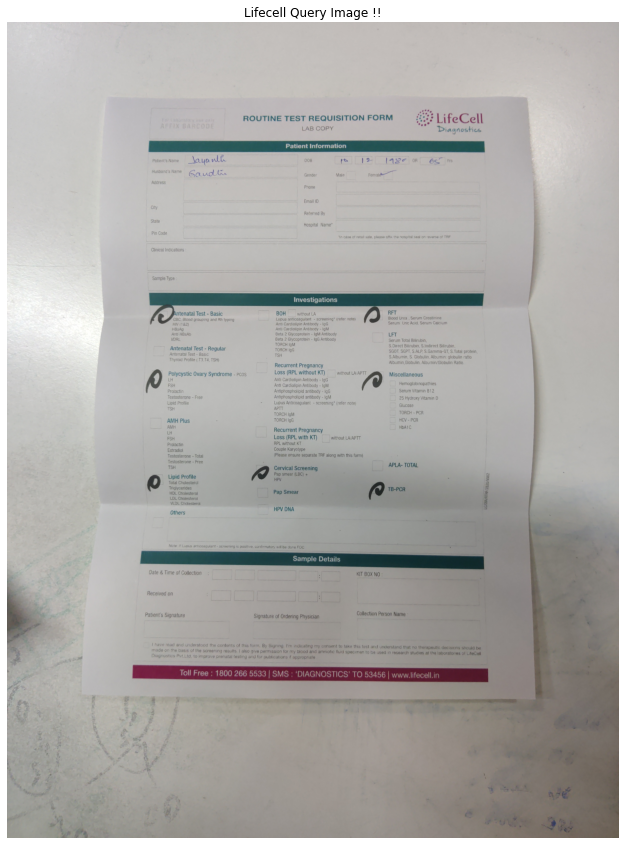

In [5]:
lifecell_query = "/Users/jaswantjonnada/Documents/TestRequestForm/data/images/lifecell/image_snap_1657721736624.jpeg"
lifecell_query_1 = "/Users/jaswantjonnada/Documents/TestRequestForm/data/images/lifecell/image_snap_1657713620770.jpeg"
lifecell_query_im = cv2.imread(lifecell_query_1)
lifecell_query_im = cv2.cvtColor(lifecell_query_im, cv2.COLOR_BGR2RGB)
lifecell_query_grey = cv2.cvtColor(lifecell_query_im, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(15, 15))
plt.title("Lifecell Query Image !!")
plt.axis('off')
plt.imshow(lifecell_query_im)

print(f'Query Image Shape: {lifecell_query_im.shape}')


## Orb Feature Matching
Reading the Keypoints for Query Image and Template

In [6]:
max_features = 3000
keep_percent = 0.1

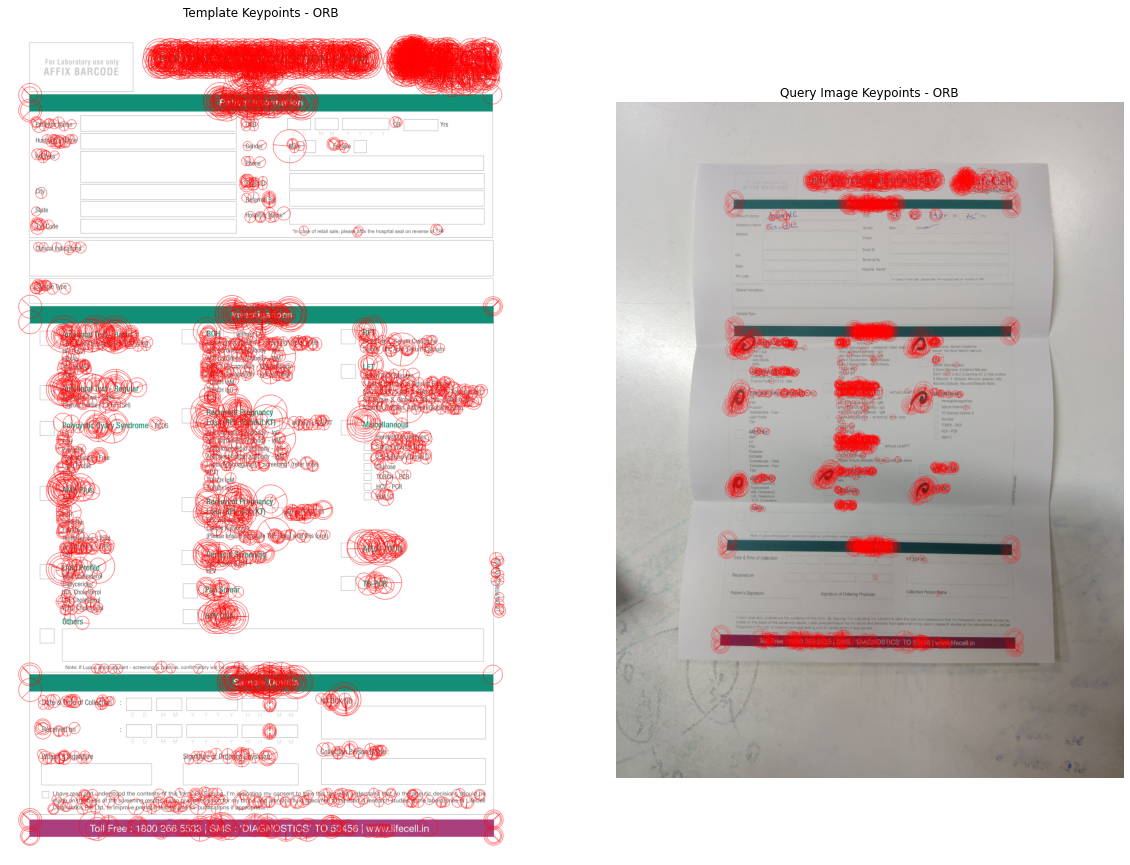

In [7]:
orb = cv2.ORB_create(max_features)
keypoints_query, descriptor_query = orb.detectAndCompute(lifecell_query_grey, None)
keypoints_template, descriptor_template = orb.detectAndCompute(lifecell_template_grey, None)

query_keypoints_im = cv2.drawKeypoints(lifecell_query_im, keypoints_query, None, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
template_keypoints_im = cv2.drawKeypoints(lifecell_template_im, keypoints_template, None, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plotting Template Images
plt.figure(figsize = (20, 40))
ax1 = plt.subplot(221)

ax1.axis('off')
ax1.set_title('Template Keypoints - ORB')
ax1.imshow(template_keypoints_im)

ax2 = plt.subplot(222)
ax2.axis('off')
ax2.set_title('Query Image Keypoints - ORB')
ax2.imshow(query_keypoints_im)


Length of matches after keeping 10% points: 300


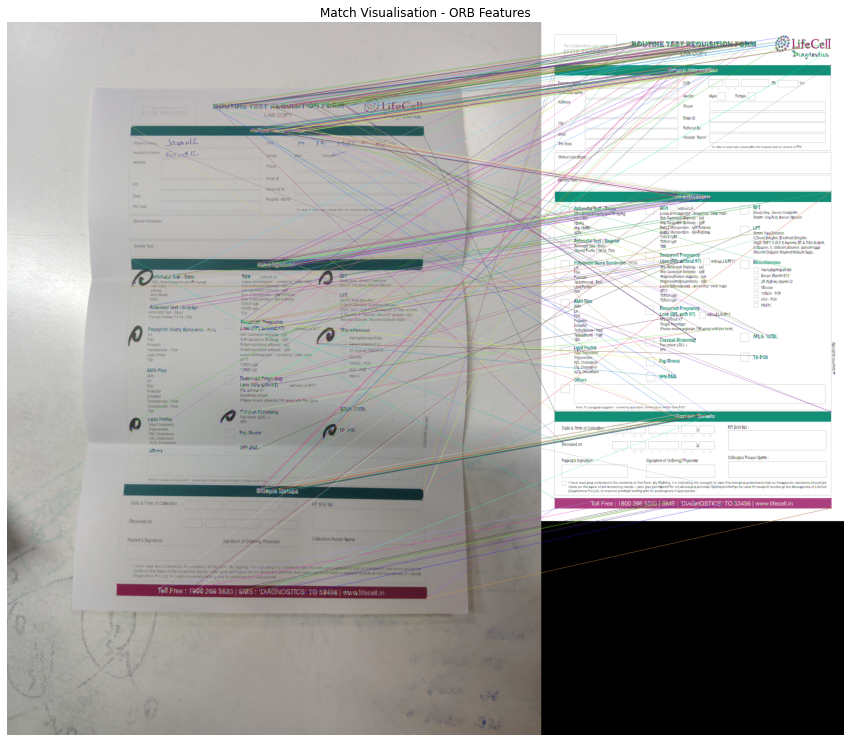

In [8]:
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = matcher.match(descriptor_query, descriptor_template)

matches = sorted(matches, key=lambda x: x.distance, reverse=False)

keep = int(len(matches) * keep_percent)
matches = matches[:keep]

print(f'Length of matches after keeping {keep_percent*100:0.0f}% points: {len(matches)}')

matched_vis = cv2.drawMatches(lifecell_query_im, keypoints_query, lifecell_template_im, keypoints_template, matches, None)

plt.figure(figsize=(15, 15))
plt.title("Match Visualisation - ORB Features")
plt.axis('off')
plt.imshow(matched_vis)

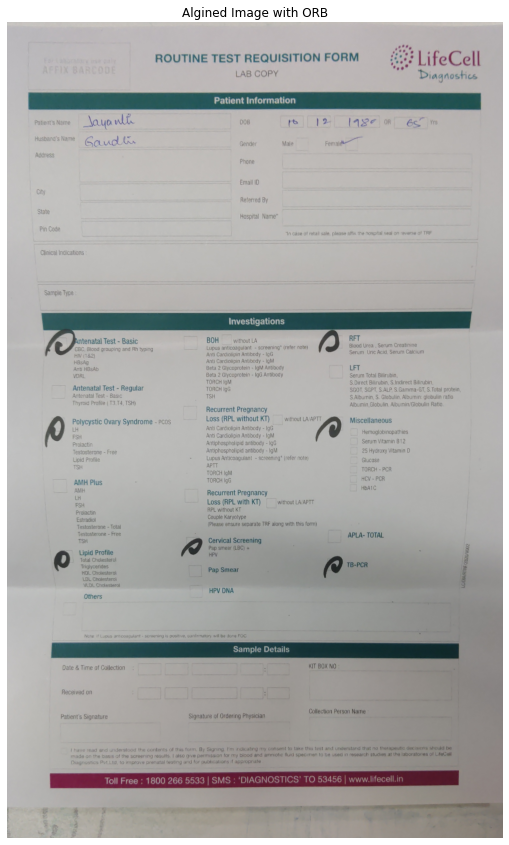

In [9]:
pts_template = np.zeros((len(matches), 2), dtype="float")
pts_query = np.zeros((len(matches), 2), dtype="float")


for i, m in enumerate(matches):
    pts_query[i, :] = keypoints_query[m.queryIdx].pt
    pts_template[i, :] = keypoints_template[m.trainIdx].pt

H, mask = cv2.findHomography(pts_query, pts_template, method=cv2.RANSAC)
h, w, channles = lifecell_template_im.shape
aligned_orb = cv2.warpPerspective(lifecell_query_im, H, (w, h))

plt.figure(figsize=(15, 15))
plt.title("Algined Image with ORB")
plt.axis('off')
plt.imshow(aligned_orb)

## Sift Features matching

Length of Keypoints, query: 13701, template: 12927


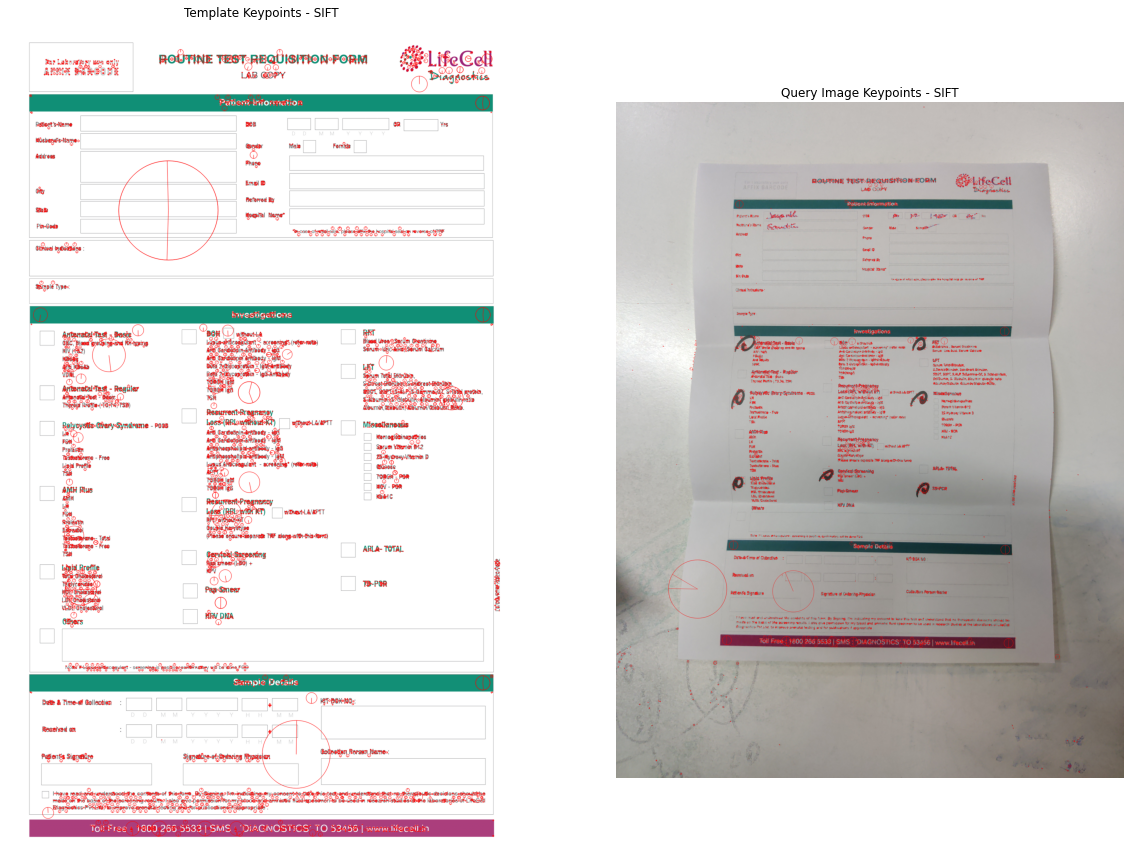

In [10]:
# Sift Features creating

sift = cv2.SIFT_create()

sift_keypoints_template, sift_descriptor_template = sift.detectAndCompute(lifecell_template_grey, None)
sift_keypoints_query, sift_descriptor_query = sift.detectAndCompute(lifecell_query_grey, None)

sift_keypoints_query_im = cv2.drawKeypoints(lifecell_query_im, sift_keypoints_query, None, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
sift_keypoints_template_im = cv2.drawKeypoints(lifecell_template_im, sift_keypoints_template, None, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print(f'Length of Keypoints, query: {len(sift_keypoints_query)}, template: {len(sift_keypoints_template)}')

# Plotting Template Images
plt.figure(figsize = (20, 40))
ax1 = plt.subplot(221)

ax1.axis('off')
ax1.set_title('Template Keypoints - SIFT')
ax1.imshow(sift_keypoints_template_im)

ax2 = plt.subplot(222)
ax2.axis('off')
ax2.set_title('Query Image Keypoints - SIFT')
ax2.imshow(sift_keypoints_query_im)


Matches Length: 13701, Length of Good matches: 1074


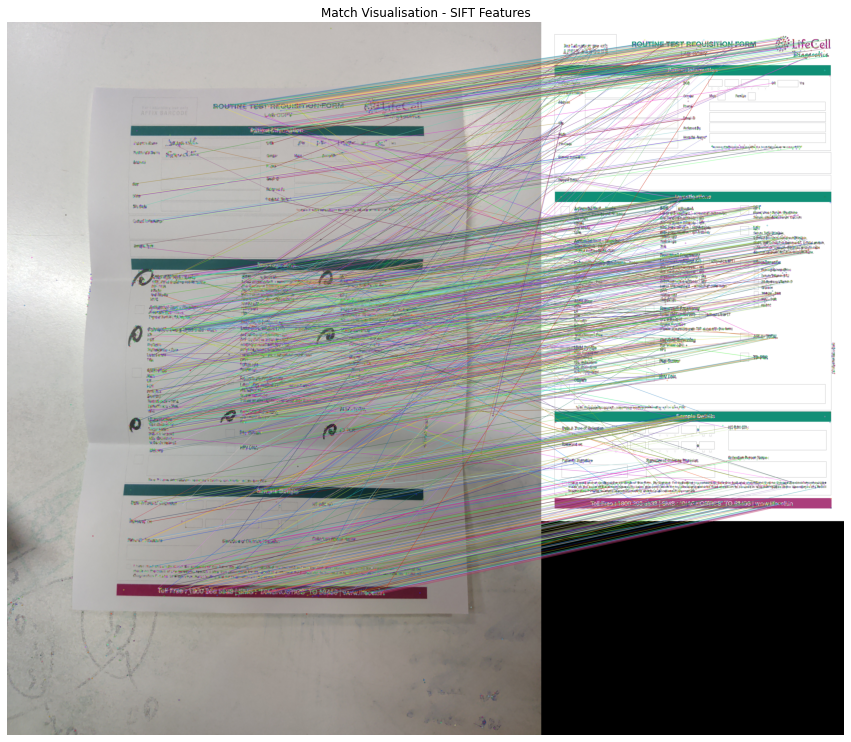

In [11]:
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.BFMatcher()


matches = matcher.knnMatch(sift_descriptor_query, sift_descriptor_template, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])


print(f'Matches Length: {len(matches)}, Length of Good matches: {len(good)}')

matched_vis = cv2.drawMatchesKnn(lifecell_query_im, sift_keypoints_query, lifecell_template_im, sift_keypoints_template, good, None)

plt.figure(figsize=(15, 15))
plt.title("Match Visualisation - SIFT Features")
plt.axis('off')
plt.imshow(matched_vis)

In [12]:
pts_template = np.zeros((len(good), 2), dtype="float")
pts_query = np.zeros((len(good), 2), dtype="float")


for i, m in enumerate(good):
    try:
        pts_query[i, :] = sift_keypoints_query[m[0].queryIdx].pt
        pts_template[i, :] = sift_keypoints_template[m[0].trainIdx].pt
    except IndexError:
        print(f'Index Error at {i}')

H, mask = cv2.findHomography(pts_query, pts_template, method=cv2.RANSAC)
h, w, channels = lifecell_template_im.shape
aligned = cv2.warpPerspective(lifecell_query_im, H, (w, h))


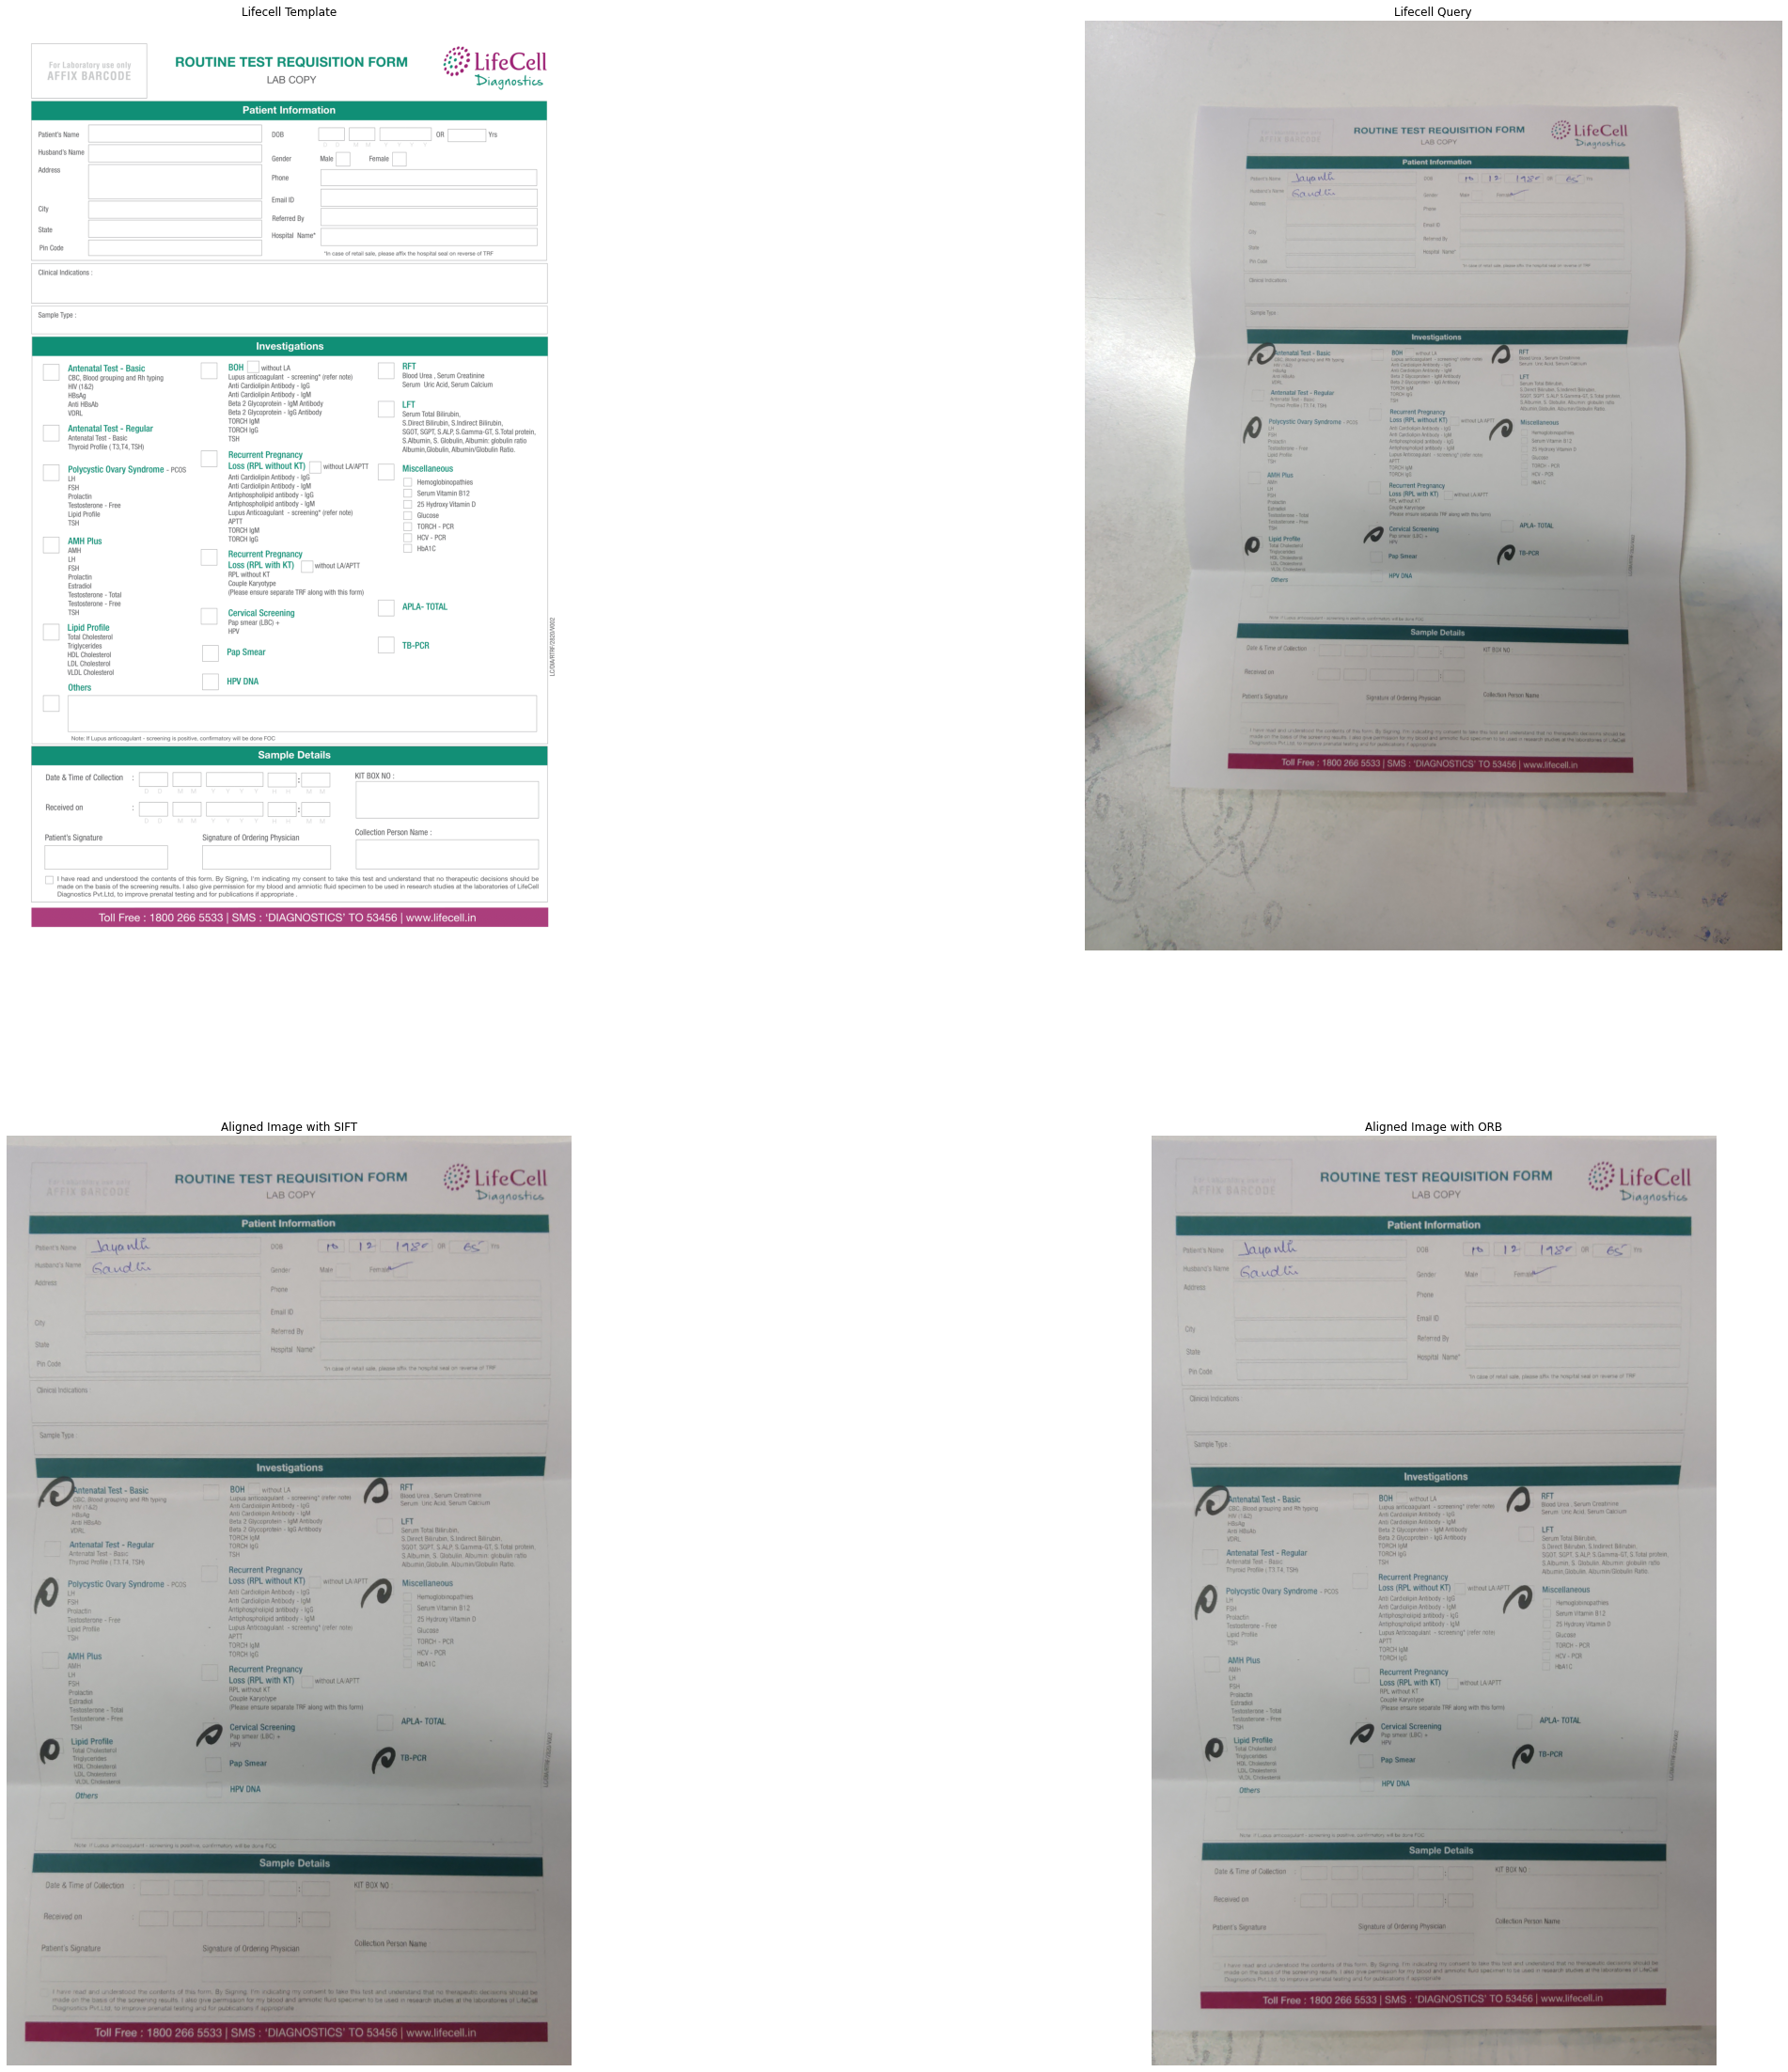

In [13]:

# Plotting all the figures

plt.figure(figsize=(40, 40))

ax1 = plt.subplot(221)
ax1.set_title("Lifecell Template")
ax1.axis('off')
ax1.imshow(lifecell_template_im)

ax2 = plt.subplot(222)
ax2.set_title("Lifecell Query")
ax2.axis("off")
ax2.imshow(lifecell_query_im)

ax3 = plt.subplot(223)
ax3.set_title("Aligned Image with SIFT")
ax3.axis("off")
ax3.imshow(aligned)

ax4 = plt.subplot(224)
ax4.set_title("Aligned Image with ORB")
ax4.axis("off")
ax4.imshow(aligned_orb)


In [14]:
type(aligned)

numpy.ndarray